In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from scipy.interpolate import interp1d
from scipy.signal import resample, find_peaks, peak_prominences
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import LeaveOneOut
from lightgbm import LGBMRegressor

from truth import IeeeGroundTruth
from wavelet import apply_wavelet
from peaks import get_peaks_v2
from signal_pross import (
    normalize_signal,
    detrend_w_poly,
    normalize_amplitude_to_1,
    n_moving_avg,
    min_max_scale,
    bandpass,
    get_ibis,
    get_hr
)
import lightgbm as lgb
from autograd import grad

%matplotlib inline
plt.rcParams['figure.figsize'] = [18, 6]

### Process data for all 7 subjects

In [3]:
truths = []
for subject in range(1, 8):

    truth = IeeeGroundTruth(subject, 1, directory = 'channel_data3')
    truth.align_rgb_bvp()
    truth.fill_nans()
    truth.process_rgb()
    truth.process_bvp()

    truths.append(truth)

### Implement custom subclass of SKLearn's RF Regressor

In [37]:
class MoodyGBM:
    
    def __init__(self, data, label_col = 'bvp', subject_col = 'subject', random_state = 0, kfold = False,
                # hyperparameters
                n_estimators = 100, objective = None, split_size = 1280, test_size = 0.3):
        
        # instance variables
        self.given_data = data
        self.label_col = label_col
        self.subject_col = subject_col
        self.split_size = split_size
        self.test_size = test_size
        self.random_state = random_state
        self.kfold = kfold
        self.tree_weights_ = None
        self.gbm = None

        # create consecutive splits in the data and then randomly sample from the splits
        splits = self.split_data()
        self.train_split_indices = random.sample(range(len(splits)), int(len(splits) * (1 - self.test_size)))
        
        # split up the training and testing splits
        self.train_splits = [splits[i] for i in self.train_split_indices]
        self.test_splits = [splits[i] for i in range(len(splits)) if i not in self.train_split_indices]
        
        # create the training dataset from the training splits
        train_indices = [idx for split in self.train_splits for idx in split]
        self.train_data = self.given_data.iloc[train_indices].drop(columns = [self.subject_col])
        # self.data = lgb.Dataset(self.train_data, label = self.label_col)
        self.train_X_sam = self.train_data.drop(columns = [self.label_col]).to_numpy()
        self.train_y_sam = self.train_data[self.label_col].to_numpy()

        # create the testing dataset from the testing splits
        test_indices = [idx for split in self.test_splits for idx in split]
        self.test_data = self.given_data.iloc[test_indices].drop(columns = [self.subject_col])
        self.test_X = self.test_data.drop(columns = [self.label_col]).to_numpy()
        self.test_y = self.test_data[self.label_col].to_numpy()

    
    def split_data(self, to_exclude = None):
        
        data_in_use = self.given_data if to_exclude is None else self.given_data[~self.given_data[self.subject_col].isin(to_exclude)]

        subject_indices = data_in_use.groupby(self.subject_col).indices
        splits = []
        for _, indices in subject_indices.items():
            
            n_splits = len(indices) // self.split_size
            if n_splits > 0:

                subject_splits = []
                for i in range(n_splits):
                    split_start = i * self.split_size
                    split_end = (i + 1) * self.split_size
                    subject_split = indices[split_start: split_end]
                    subject_splits.append(subject_split)
                
                splits.extend(subject_splits)
        
        return splits

    def set_params(self, **params):
        new_params = deepcopy(super().get_params())
        new_params['learning_rate'] = 0.123
        super().set_params(**new_params)

    def fit(self):
        self.gbm.fit(self.train_X_sam, self.train_y_sam)

    def predict(self, X):
        return self.gbm.predict(X)

    def eval(self):
        return mean_squared_error(self.test_y, self.predict(self.test_X))

    @staticmethod
    def _process(targs, signal, smoothing_window = 10, use_bandpass = False):
        
        orig_len = len(signal)
        signal = n_moving_avg(signal, smoothing_window)
        signal = resample(signal, orig_len)
        if use_bandpass:
            signal = bandpass(signal, 64, [0.67, 3.0], 4)
        signal = min_max_scale(signal)
        
        targs = n_moving_avg(targs, 20)
        targs = resample(targs, orig_len)
        targs = min_max_scale(targs)
        
        return targs, signal


def custom_loss(y_true, y_pred):
    error = y_pred-y_true
    grad = 2 * error
    hess = 0 * error + 2
    return grad, hess


### Train the model on all subjects except 1

In [44]:
test_subject = 7
test_subject_truth = truths[test_subject - 1]

data_arr = []
for i in range(len(truths)):
    
    if i == (test_subject - 1):
        continue
    
    truth = truths[i]
    data = truth.prepare_data_for_ml()
    data = data.iloc[1000: 15000, :]
    
    data['subject'] = i + 1
    data_arr.append(data)

data = pd.concat(data_arr)

rf = MoodyGBM(data, n_estimators = 100)
rf.fit()
mse = rf.eval()

print(f'MSE: {mse}')
# print(f'HR error: {hr_errs}')
# print(f'HR Error absolute: {hr_errs_absolute}')
# print(f'Feature importances:')
# display(rf.feature_importances())


MSE: 0.0056664667977331575


In [26]:
# data_arr = []
# for i in range(len(truths)):
        
#     truth = truths[i]
#     data = truth.prepare_data_for_ml()
#     data = data.iloc[1000: 15000, :]
    
#     data['subject'] = i + 1
#     data_arr.append(data)

# data = pd.concat(data_arr)

# rf = MoodTriggersRegressor(data, n_estimators = 100, kfold = True)
# mean_mse, mean_hr_err, mean_sqrt_hr_err, summary = rf.eval_kfold()

# print(mean_mse, mean_hr_err, mean_sqrt_hr_err)
# summary

In [ ]:
rec = {
    'w/o wave': (0.014966182095387174, 696.1679901518303),
    'w/ wave': (0.06851164298744652, 335.74974096112766),
    'w/ bandpass and wave w/ bandpass first': (0.02288918317382276, 883.0830443688016),
    'w/ bandpass and wave w/ wave first': (0.013029571137835922, 619.7491567908635),
    'w/ min max scaling and everything else': (0.006137550724635535, 527.8052162904935),
    'w/ prev but also with chrom': (0.0053205282220937684, 532.8225611310841)
}

True HR: 87.87185354691076; Pred HR: 89.68152866242038


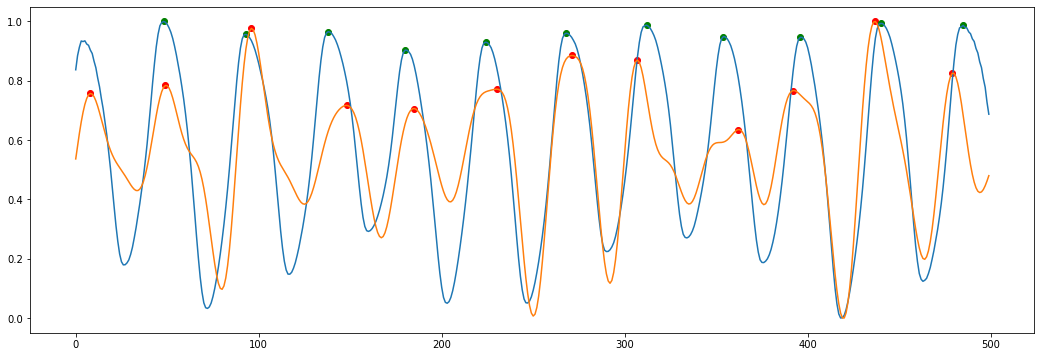

In [46]:
beg = 3000
end = 3500

# get data for subject not in test set and get x and y for prediction
data = truths[5].prepare_data_for_ml()
x = data.drop(columns = ['bvp']).to_numpy()
y = data['bvp'].to_numpy()

targ = y[beg: end]
pred = rf.predict(x)[beg: end]
targ, pred = rf._process(targ, pred)
# pred = apply_wavelet(pred, 'db2', 2)
pred = bandpass(pred, 64, [0.67, 3.0], 4)
pred = min_max_scale(pred)

pred_peaks, _ = get_peaks_v2(pred, 64, 3.0, 0.1, prominence = 0.2, with_min_dist = True, with_valleys = False)
true_peaks, _ = get_peaks_v2(targ, 64, 3.0, -1, prominence = 0.1, with_min_dist = True, with_valleys = False)

plt.plot(targ)
plt.plot(pred)
plt.scatter(pred_peaks, pred[pred_peaks], c='r')
plt.scatter(true_peaks, targ[true_peaks], c='g')

pred_ibis = get_ibis(pred_peaks, 64)
true_ibis = get_ibis(true_peaks, 64)
pred_hr = get_hr(pred_ibis)
true_hr = get_hr(true_ibis)
print(f'True HR: {true_hr}; Pred HR: {pred_hr}')


In [ ]:
import numpy as np
from sklearn.metrics import mutual_info_score
from sklearn.preprocessing import KBinsDiscretizer

def normalized_mutual_information(x, y, n_bins=10):
    # Discretize the continuous variables using a fixed number of bins
    discretizer = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')
    
    x_discrete = discretizer.fit_transform(x.reshape(-1, 1)).ravel().astype(int)
    y_discrete = discretizer.fit_transform(y.reshape(-1, 1)).ravel().astype(int)

    # Compute mutual information between the discretized variables
    mi = mutual_info_score(x_discrete, y_discrete)

    # Normalize the mutual information by the entropy of the two variables
    entropy_x = -np.sum(np.bincount(x_discrete) / len(x_discrete) * np.log2(np.bincount(x_discrete) / len(x_discrete) + np.finfo(float).eps))
    entropy_y = -np.sum(np.bincount(y_discrete) / len(y_discrete) * np.log2(np.bincount(y_discrete) / len(y_discrete) + np.finfo(float).eps))

    nmi = mi / np.sqrt(entropy_x * entropy_y)
    return nmi

# Test the function with two continuous variables
x = np.random.rand(100)
y = 2 * x + np.random.normal(0, 0.1, 100)

nmi = normalized_mutual_information(x, y)
print("Normalized mutual information:", nmi)


Normalized mutual information: 0.49030957956311305


NMI: 0.2601083272828991
1200 1200


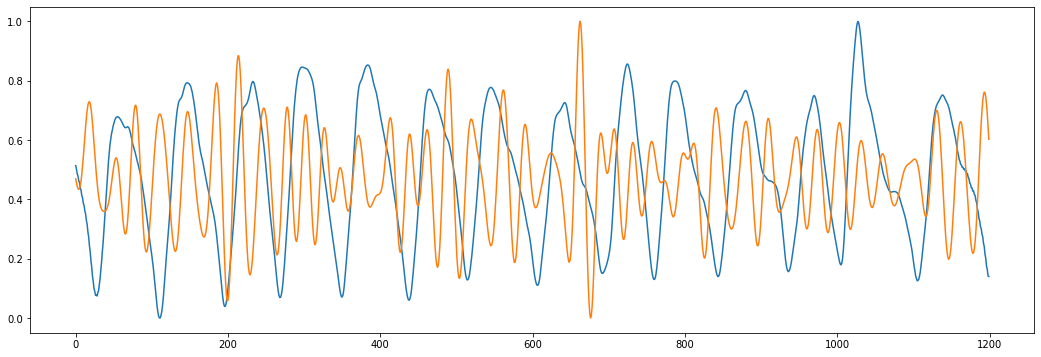

In [ ]:
from chrominance import chrominance, CHROM_SETTINGS

sig = data[['r', 'g', 'b']].to_numpy()
chrom = chrominance(sig, CHROM_SETTINGS, None, False)
chrom = chrom[beg: end]
# plt.plot(chrom)
chrom = apply_wavelet(chrom, 'db2', 2)
# plt.plot(chrom)
chrom = bandpass(chrom, 64, [0.67, 3.0], 4)
chrom = min_max_scale(chrom)
plt.plot(targ)
plt.plot(chrom)
print(f'NMI: {normalized_mutual_information(targ, chrom, n_bins = 100)}')
print(len(chrom), len(pred))

In [ ]:
# beg = 1200
# end = 2400

# # get data for subject not in test set and get x and y for prediction
# data = truths[test_subject-1].prepare_data_for_ml()
# x = data.drop(columns = ['bvp']).to_numpy()

# y = data['bvp'].to_numpy()
# targ = [truths[test_subject-1].bvp[0]]
# for i in range(len(y)):
#     targ.append(targ[i] + y[i])
# targ = targ[beg: end]

# pred = rf.predict(x)[beg: end]
# pred_official = [truths[test_subject-1].bvp[0]]
# for i in range(len(pred)):
#     pred_official.append(pred_official[i] + pred[i])
# targ, pred = rf._process(targ, pred_official)
# pred = detrend_w_poly(pred)
# pred = min_max_scale(pred)

# pred_peaks, _ = get_peaks_v2(pred, 64, 3.0, 0.1, prominence = 0.15, with_min_dist = True, with_valleys = False)
# true_peaks, _ = get_peaks_v2(targ, 64, 3.0, -1, prominence = 0, with_min_dist = True, with_valleys = False)

# plt.plot(targ)
# plt.plot(pred)
# plt.scatter(pred_peaks, pred[pred_peaks], c='r')
# plt.scatter(true_peaks, targ[true_peaks], c='g')

# pred_ibis = get_ibis(pred_peaks, 64)
# true_ibis = get_ibis(true_peaks, 64)
# pred_hr = get_hr(pred_ibis)
# true_hr = get_hr(true_ibis)
# print(f'True HR: {true_hr}; Pred HR: {pred_hr}')

In [ ]:
type(data.indices)

AttributeError: 'DataFrame' object has no attribute 'indices'